# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

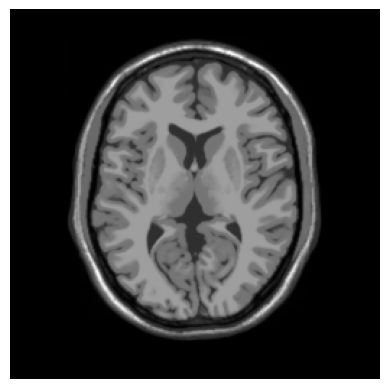

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import cv2

if not os.path.exists("MR_data.mat"):
    !wget https: // raw.githubusercontent.com / vision-agh / poc_sw / master / 07_Bilateral / MR_data.mat --no-check-certificate

mat = loadmat("MR_data.mat")

I_noisefree = mat["I_noisefree"]
I_noisy1 = mat["I_noisy1"]
I_noisy2 = mat["I_noisy2"]
I_noisy3 = mat["I_noisy3"]
I_noisy4 = mat["I_noisy4"]

plt.imshow(I_noisefree, 'gray')
plt.axis("off")
plt.show()

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

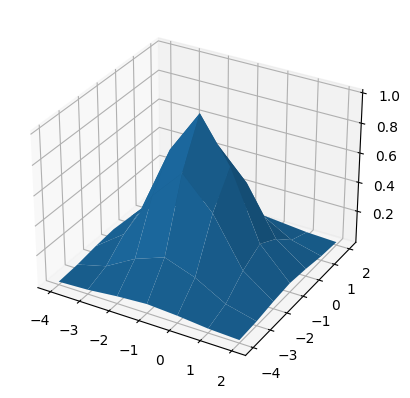

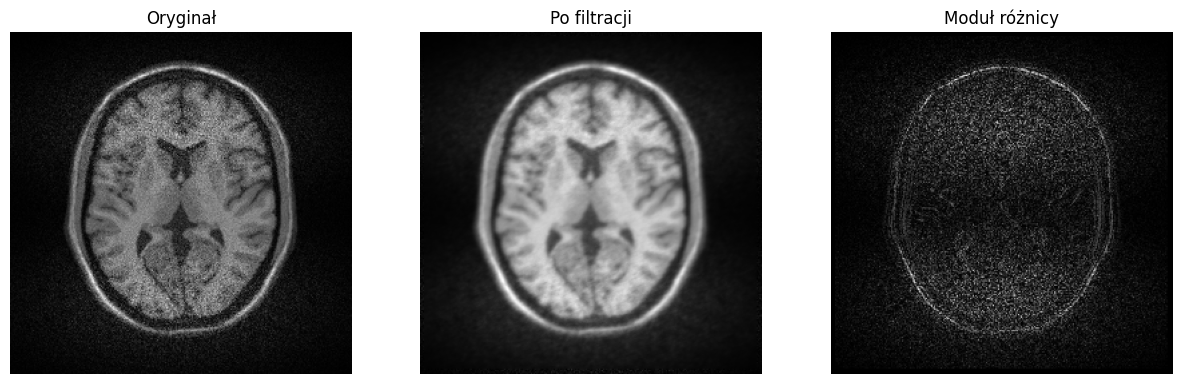

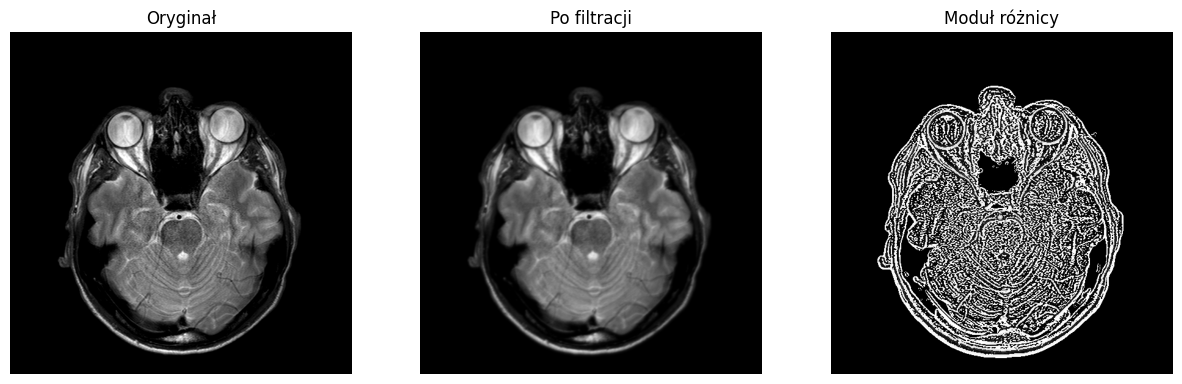

In [2]:
def gaussian_filter(size, sigma):
    m = n = size
    h, k = m // 2, n // 2
    x, y = np.mgrid[-h:h + 1, -k:k + 1]
    g = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

    return g


def mesh(fun, size):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    X = np.arange(-size // 2, size // 2, 1)
    Y = np.arange(-size // 2, size // 2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun

    ax.plot_surface(X, Y, Z)

    plt.show()


gaussian_kernel_05 = gaussian_filter(7, 1.2)
mesh(gaussian_kernel_05, 7)


def new_pixel_value(frame, g_filter):
    return np.sum(np.multiply(frame, g_filter)) / np.sum(g_filter)


def convolution(img, size, sigma):
    g_filter = gaussian_filter(size, sigma)
    conv_img = img.copy()

    for i, _ in enumerate(conv_img[size // 2: -size // 2]):
        for j, _ in enumerate(conv_img[size // 2: -size // 2]):
            frame = conv_img[i: i + size, j: j + size]
            conv_img[i + size // 2, j + size // 2] = new_pixel_value(frame, g_filter)

    return conv_img


def display_1(img, filtered_img):
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(15, 10)
    axs[0].imshow(img, 'gray')
    axs[0].axis("off")
    axs[0].set_title("Oryginał")

    axs[1].imshow(filtered_img, 'gray')
    axs[1].axis("off")
    axs[1].set_title("Po filtracji")

    axs[2].imshow(np.abs(img - filtered_img), 'gray')
    axs[2].axis("off")
    axs[2].set_title("Moduł różnicy")

    plt.show()


display_1(I_noisy2, convolution(I_noisy2, 7, 1.2))
display_1(I_noisy3, convolution(I_noisy3, 7, 1.2))


### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [ ]:
def bilateral_pixel_value(frame, g_filter, sigma_r):
    size = frame.shape[0]
    pix = 0
    normalize = 0
    for i in range(size):
        for j in range(size):
            filter_v = g_filter[i, j]

            gamma_result = np.exp(-(((frame[size // 2, size // 2] - frame[i, j]) ** 2) / (2 * (sigma_r ** 2))))

            pix += frame[j, i] * filter_v * gamma_result
            normalize += filter_v * gamma_result

    return pix / normalize


def bilateral_convolution(img, size, sigma, sigma_r):
    g_filter = gaussian_filter(size, sigma)
    conv_img = img.copy()

    for i, _ in enumerate(conv_img[size // 2: -size // 2]):
        for j, _ in enumerate(conv_img[size // 2: -size // 2]):
            frame = conv_img[i: i + size, j: j + size]
            conv_img[i + size // 2, j + size // 2] = bilateral_pixel_value(frame, g_filter, sigma_r)

    return conv_img


# display_1(I_noisy1, bilateral_convolution(I_noisy1, 5, 0.9, 2))
display_1(I_noisy4, bilateral_convolution(I_noisy4, 5, 0.9, 2))

C:\Users\roman\AppData\Local\Temp\ipykernel_22504\928904135.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  gamma_result = np.exp(-(((frame[size // 2, size // 2] - frame[i, j]) ** 2) / (2 * (sigma_r ** 2))))
